<a href="https://colab.research.google.com/github/liangnic/COMP5703-CS36-1/blob/main/models/ResNet50_FineTune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras as k

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D

from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
import zipfile

# Download the data(10% of 10 food classes from Food101)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

# Walk through 10% data directory and list number of files...
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

--2023-09-08 02:33:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.162.207, 74.125.31.207, 173.194.211.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.162.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  66.1MB/s    in 2.4s    

2023-09-08 02:33:36 (66.1 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images i

In [ ]:
train_dir = "10_food_classes_10_percent/test/"
test_dir = "10_food_classes_10_percent/train/"

Filepath

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
PATH = '/content/drive/MyDrive/COMP5703/resnet50_model.h5'

Testing GPU

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Data augmentation

In [ ]:
N_CLASS = 10
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

print("Training images:")
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=IMAGE_SHAPE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle=True)

print("Testing images:")
validation_generator = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical',
                                                        shuffle=True)

Training images:
Found 2500 images belonging to 10 classes.
Testing images:
Found 750 images belonging to 10 classes.


# Resnet50 - Initial - Don't run

In [ ]:
resnet50 = ResNet50(weights='imagenet', pooling='avg', include_top=False)

In [ ]:
resnet50.summary()

In [ ]:
x = resnet50.output
#x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.02)(x)   #Dropout to prevent overfitting

predictions = Dense(N_CLASS, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=resnet50.input, outputs=predictions)

model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

history_resnet50 = model.fit_generator(train_generator,
                    validation_data=validation_generator,
                    epochs=10,
                    verbose=1)


<ipython-input-24-ef2632cacffb>:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_resnet50 = model.fit_generator(train_generator,


Epoch 1/10
79/79 [==============================] - 68s 608ms/step - loss: 0.9453 - accuracy: 0.7488 - val_loss: 3.0487 - val_accuracy: 0.0893
Epoch 2/10
79/79 [==============================] - 48s 604ms/step - loss: 0.3722 - accuracy: 0.9184 - val_loss: 3.4112 - val_accuracy: 0.1000
Epoch 3/10
79/79 [==============================] - 47s 596ms/step - loss: 0.3075 - accuracy: 0.9408 - val_loss: 3.7685 - val_accuracy: 0.1027
Epoch 4/10
79/79 [==============================] - 47s 589ms/step - loss: 0.2538 - accuracy: 0.9496 - val_loss: 3.6540 - val_accuracy: 0.1120
Epoch 5/10
79/79 [==============================] - 48s 602ms/step - loss: 0.2211 - accuracy: 0.9616 - val_loss: 3.4621 - val_accuracy: 0.1413
Epoch 6/10
79/79 [==============================] - 67s 845ms/step - loss: 0.2012 - accuracy: 0.9684 - val_loss: 3.0870 - val_accuracy: 0.2560
Epoch 7/10
79/79 [==============================] - 52s 662ms/step - loss: 0.1754 - accuracy: 0.9744 - val_loss: 2.4379 - val_accuracy: 0.4227

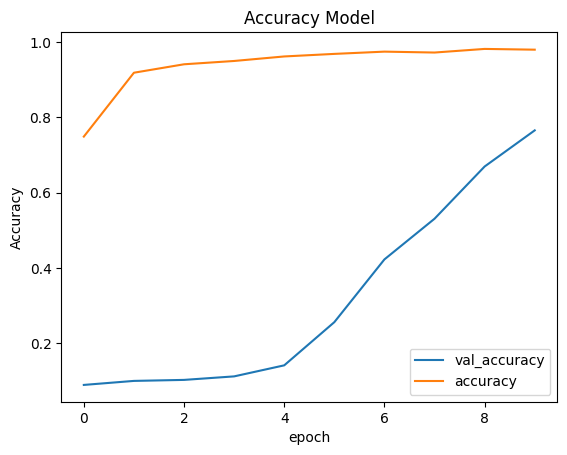

In [ ]:
import matplotlib.pyplot as plt

plt.title('Accuracy Model')
plt.plot(history_resnet50.history['val_accuracy'])
plt.plot(history_resnet50.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['val_accuracy', 'accuracy'], loc='best')
plt.show()

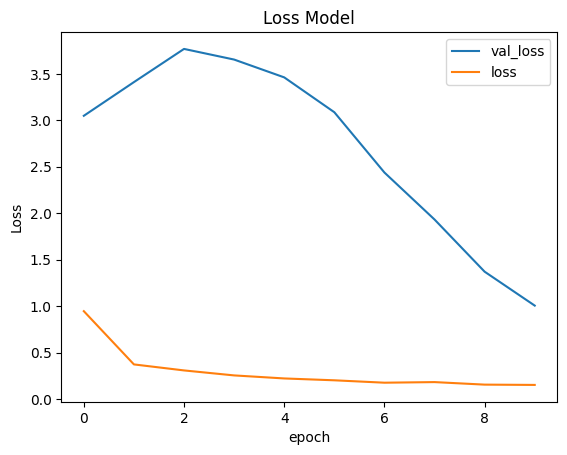

In [ ]:
plt.title('Loss Model')
plt.plot(history_resnet50.history['val_loss'])
plt.plot(history_resnet50.history['loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['val_loss', 'loss'], loc='best')
plt.show()

# Tunnnnnnning - Run here for fine-tune

In [ ]:
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping

In [ ]:
model = tf.keras.models.load_model(PATH)

In [ ]:
model.summary()

In [ ]:
len(model.trainable_variables)

216

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
print("Number of layers in the base model: ", len(model.layers))

model.trainable = True
print("Number of layers in the base model: ", len(model.layers))

Number of layers in the base model:  179
Number of layers in the base model:  179


In [ ]:
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

#Callback for model saving and reducing learning rate on plateau
callbacks_list = [callbacks.ModelCheckpoint(
        filepath = PATH,
        monitor = 'val_loss',
        save_best_only = True),
        callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.1,
            patience=2,
            mode='auto',
            min_delta=0.002,
            min_lr=1e-8),
        callbacks.EarlyStopping(
            monitor='val_accuracy',
            min_delta=0.001,
            patience=3,
            verbose=1,
            mode='auto',
            baseline=None)]


In [ ]:
history = model.fit_generator(train_generator,
                    validation_data=validation_generator,
                    epochs=20,
                    verbose=1,
                    callbacks = callbacks_list)

<ipython-input-36-fb41ded1a972>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/20
79/79 [==============================] - 79s 641ms/step - loss: 0.1324 - accuracy: 0.9880 - val_loss: 0.9518 - val_accuracy: 0.7867 - lr: 0.0010
Epoch 2/20
79/79 [==============================] - 57s 714ms/step - loss: 0.1368 - accuracy: 0.9844 - val_loss: 0.8800 - val_accuracy: 0.8080 - lr: 0.0010
Epoch 3/20
79/79 [==============================] - 49s 614ms/step - loss: 0.1257 - accuracy: 0.9888 - val_loss: 0.9006 - val_accuracy: 0.8067 - lr: 0.0010
Epoch 4/20
79/79 [==============================] - 50s 634ms/step - loss: 0.1248 - accuracy: 0.9896 - val_loss: 0.8917 - val_accuracy: 0.8053 - lr: 0.0010
Epoch 5/20
79/79 [==============================] - 49s 615ms/step - loss: 0.1224 - accuracy: 0.9864 - val_loss: 0.8961 - val_accuracy: 0.8053 - lr: 1.0000e-04
Epoch 5: early stopping


Train weights of all the layers in the model from layer 5

In [ ]:
for layer in [l for l in model.layers if 'conv5' not in l.name]:
   layer.trainable = False
for layer in [l for l in model.layers if 'conv5' in l.name or l.name == 'probs']:
   layer.trainable = True

print('conv_5 is now trainable')

conv_5 is now trainable


In [ ]:
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

#Callback for model saving and reducing learning rate on plateau
callbacks_list = [callbacks.ModelCheckpoint(
        filepath = PATH,
        monitor = 'val_loss',
        save_best_only = True),
        callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.1,
            patience=2,
            mode='auto',
            min_delta=0.002,
            min_lr=1e-8),
        callbacks.EarlyStopping(
            monitor='val_accuracy',
            min_delta=0.001,
            patience=3,
            verbose=1,
            mode='auto',
            baseline=None)]

In [ ]:
history = model.fit_generator(train_generator,
                    validation_data=validation_generator,
                    epochs=15,
                    verbose=1,
                    callbacks = callbacks_list)

<ipython-input-47-2a84ae1e7ab4>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/15
79/79 [==============================] - 55s 607ms/step - loss: 0.1099 - accuracy: 0.9944 - val_loss: 0.8916 - val_accuracy: 0.8067 - lr: 0.0010
Epoch 2/15
79/79 [==============================] - 53s 673ms/step - loss: 0.1127 - accuracy: 0.9936 - val_loss: 0.8776 - val_accuracy: 0.8147 - lr: 0.0010
Epoch 3/15
79/79 [==============================] - 44s 562ms/step - loss: 0.1036 - accuracy: 0.9956 - val_loss: 0.8939 - val_accuracy: 0.8040 - lr: 0.0010
Epoch 4/15
79/79 [==============================] - 47s 591ms/step - loss: 0.1055 - accuracy: 0.9956 - val_loss: 0.8967 - val_accuracy: 0.8080 - lr: 0.0010
Epoch 5/15
79/79 [==============================] - 45s 568ms/step - loss: 0.1019 - accuracy: 0.9976 - val_loss: 0.8956 - val_accuracy: 0.8080 - lr: 1.0000e-04
Epoch 5: early stopping


-----can't go higher------

In [ ]:
model.evaluate(validation_generator)

24/24 [==============================] - 3s 120ms/step - loss: 0.8956 - accuracy: 0.8080


[0.8955681324005127, 0.8080000281333923]

Show current learning rate

In [ ]:
import keras.backend as K
print(K.eval(model.optimizer.lr))

0.000100000005


Unfreeze all the layers, use the new learning rate

In [ ]:
model.trainable = True

In [ ]:
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
callbacks_list = [callbacks.ModelCheckpoint(
        filepath = PATH,
        monitor = 'val_loss',
        save_best_only = True),
        callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.1,
            patience=2,
            mode='auto',
            min_delta=0.002,
            min_lr=1e-8),
        callbacks.EarlyStopping(
            monitor='val_accuracy',
            min_delta=0.001,
            patience=3,
            verbose=1,
            mode='auto',
            baseline=None)]

history = model.fit_generator(train_generator,
                    validation_data=validation_generator,
                    epochs=10,
                    verbose=1,
                    callbacks = callbacks_list)

<ipython-input-62-0dce30975211>:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/10
79/79 [==============================] - 79s 730ms/step - loss: 0.1013 - accuracy: 0.9952 - val_loss: 0.9076 - val_accuracy: 0.8093 - lr: 1.0000e-04
Epoch 2/10
79/79 [==============================] - 52s 647ms/step - loss: 0.1049 - accuracy: 0.9948 - val_loss: 0.9100 - val_accuracy: 0.8093 - lr: 1.0000e-04
Epoch 3/10
79/79 [==============================] - 52s 663ms/step - loss: 0.1050 - accuracy: 0.9940 - val_loss: 0.9040 - val_accuracy: 0.8120 - lr: 1.0000e-04
Epoch 4/10
79/79 [==============================] - 49s 624ms/step - loss: 0.1027 - accuracy: 0.9944 - val_loss: 0.9095 - val_accuracy: 0.8093 - lr: 1.0000e-04
Epoch 5/10
79/79 [==============================] - 50s 634ms/step - loss: 0.1067 - accuracy: 0.9936 - val_loss: 0.9141 - val_accuracy: 0.8040 - lr: 1.0000e-04
Epoch 6/10
79/79 [==============================] - 50s 632ms/step - loss: 0.1057 - accuracy: 0.9928 - val_loss: 0.9128 - val_accuracy: 0.8053 - lr: 1.0000e-05
Epoch 6: early stopping


#Output score Graphs

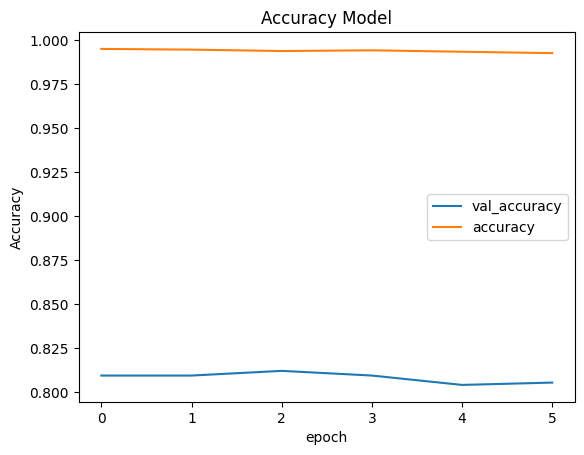

In [ ]:
plt.title('Accuracy Model')
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['val_accuracy', 'accuracy'], loc='best')
plt.show()

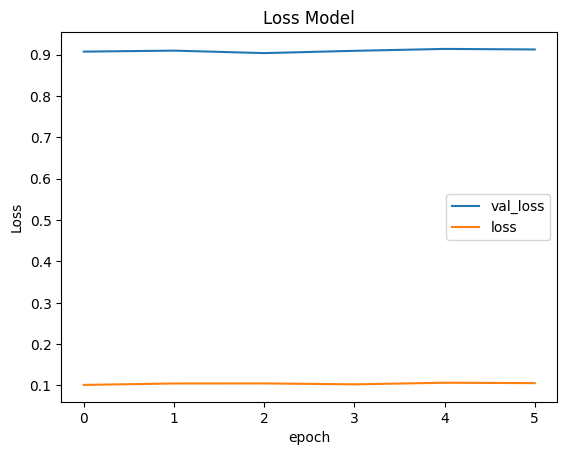

In [ ]:
plt.title('Loss Model')
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['val_loss', 'loss'], loc='best')
plt.show()